In [6]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

#emcee
import emcee
import corner as corner
import time

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

### TQDM
from tqdm import tqdm_notebook

In [7]:
def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

# PARSEC

In [8]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

In [9]:
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r12-l33.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

<ipython-input-9-c45f30211bba>:4: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


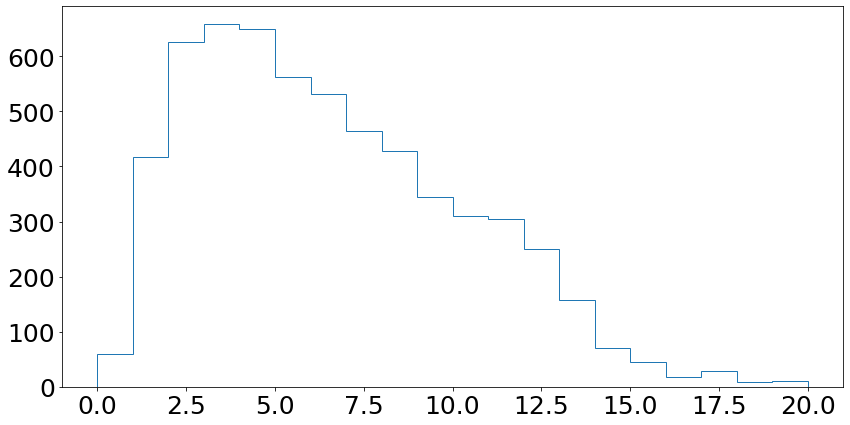

In [10]:
k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]


# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()

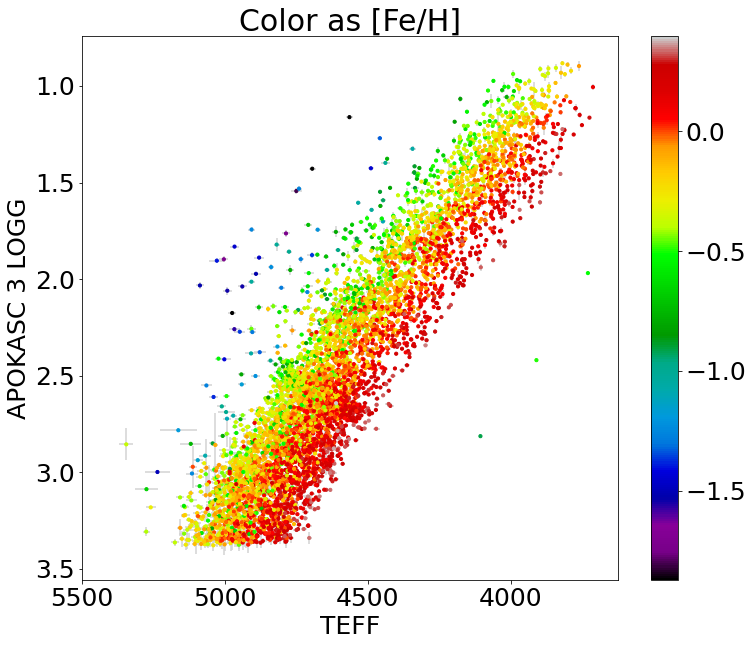

In [11]:
plt.figure(figsize=[12,10])
plt.scatter(kdr17['TEFF'],k674['APOKASC3P_LOGG'],c=kdr17['FE_H'],s=10,cmap='nipy_spectral')
plt.colorbar()
plt.errorbar(kdr17['TEFF'],k674['APOKASC3P_LOGG'],xerr=kdr17['TEFF_ERR'],yerr=k674['APOKASC3P_LOGG_ERR'],
             ls=' ',c='lightgrey',zorder=0)

plt.xlim(right=5500)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'TEFF')
plt.ylabel(r'APOKASC 3 LOGG');

# Gaia EDR3

In [12]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

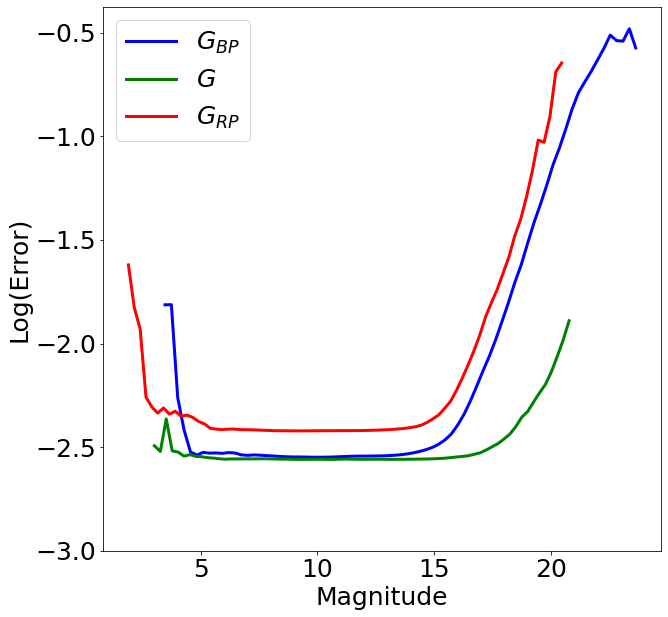

In [13]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = IUS(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

In [14]:
# def logg_cal_jonsson(logg,mh):
#     '''
#     ASPCAP Log(g) calibration from J\"{o}nsson et al. 2020
    
#     Inputs:
#     ------
#         logg: uncalibrated log(g) value (FPARAM[1])
#         mh: unclaibrated [M/H] value (FPARAM[3])
    
#     Output:
#     ------
#         cal_logg: calibrated Log(g) value
#     '''
    
#     X = (logg, mh)
    
#     def one(X):
#         '''
#         (logg>=1.2795)&(mh>0.5)
#         '''
#         logg, mh = X
#         return -0.441 + 0.7588*logg - 0.2667*logg**2 + 0.02819*logg**3 + 0.1346*0.5

#     def two(X):
#         '''
#         (logg>=1.2795)&(mh<=0.5)
#         '''
#         logg, mh = X
#         return -0.441 + 0.7588*logg - 0.2667*logg**2 + 0.02819*logg**3 + 0.1346*mh

#     def three(X):
#         '''
#         (logg<1.2795)&(mh>0.5)
#         '''
#         logg, mh = X
#         return -0.441 + 0.7588*(1.2745) - 0.2667*(1.2745)**2 + 0.02819*(1.2745)**3 + 0.1346*0.5
    
#     def four(X):
#         '''
#         (logg<1.2795)&(mh<=0.5)
#         '''
#         logg, mh = X
#         return -0.441 + 0.7588*(1.2745) - 0.2667*(1.2745)**2 + 0.02819*(1.2745)**3 + 0.1346*mh

#     result = np.piecewise(
#         X,
#         [(logg>=1.2795)&(mh>0.5), (logg>=1.2795)&(mh<=0.5), (logg<1.2795)&(mh>0.5), (logg<1.2795)&(mh<=0.5)],
#         [lambda y: logg - one(y), lambda y: logg - two(y), lambda y: logg - three(y), lambda y: logg - four(y)],
#     )
#     return result

In [15]:
def logg_cal_jonsson(logg,mh):
    '''
    ASPCAP Log(g) calibration from J\"{o}nsson et al. 2020
    
    Inputs:
    ------
        logg:    array_like
                 uncalibrated log(g) value (FPARAM[1])
                  
        mh:      array_like
                 unclaibrated [M/H] value (FPARAM[3])
    
    Output:
    ------
        loggcal: array
                 calibrated Log(g) value
    '''
    
    cal = 999999.0*np.ones(len(logg))
    
    for i in range(len(cal)):
        if (logg[i]>=1.2795)&(mh[i]>0.5):
            cal[i] = -0.441 + 0.7588*logg[i] - 0.2667*logg[i]**2 + 0.02819*logg[i]**3 + 0.1346*0.5

        elif (logg[i]>=1.2795)&(mh[i]<=0.5):
            cal[i] = -0.441 + 0.7588*logg[i] - 0.2667*logg[i]**2 + 0.02819*logg[i]**3 + 0.1346*mh[i]

        elif (logg[i]<1.2795)&(mh[i]>0.5):
            cal[i] = -0.441 + 0.7588*(1.2745) - 0.2667*(1.2745)**2 + 0.02819*(1.2745)**3 + 0.1346*0.5

        elif (logg[i]<1.2795)&(mh[i]<=0.5):
            cal[i] = -0.441 + 0.7588*(1.2745) - 0.2667*(1.2745)**2 + 0.02819*(1.2745)**3 + 0.1346*mh[i]
    
    return np.subtract(logg,cal)

Fit Parameters:
a = 0.97583; -0.44100
b = 2.65432; 0.75880
c = -0.73250; -0.26670
d = 0.09939; 0.02819
e = 0.20734; 0.13460


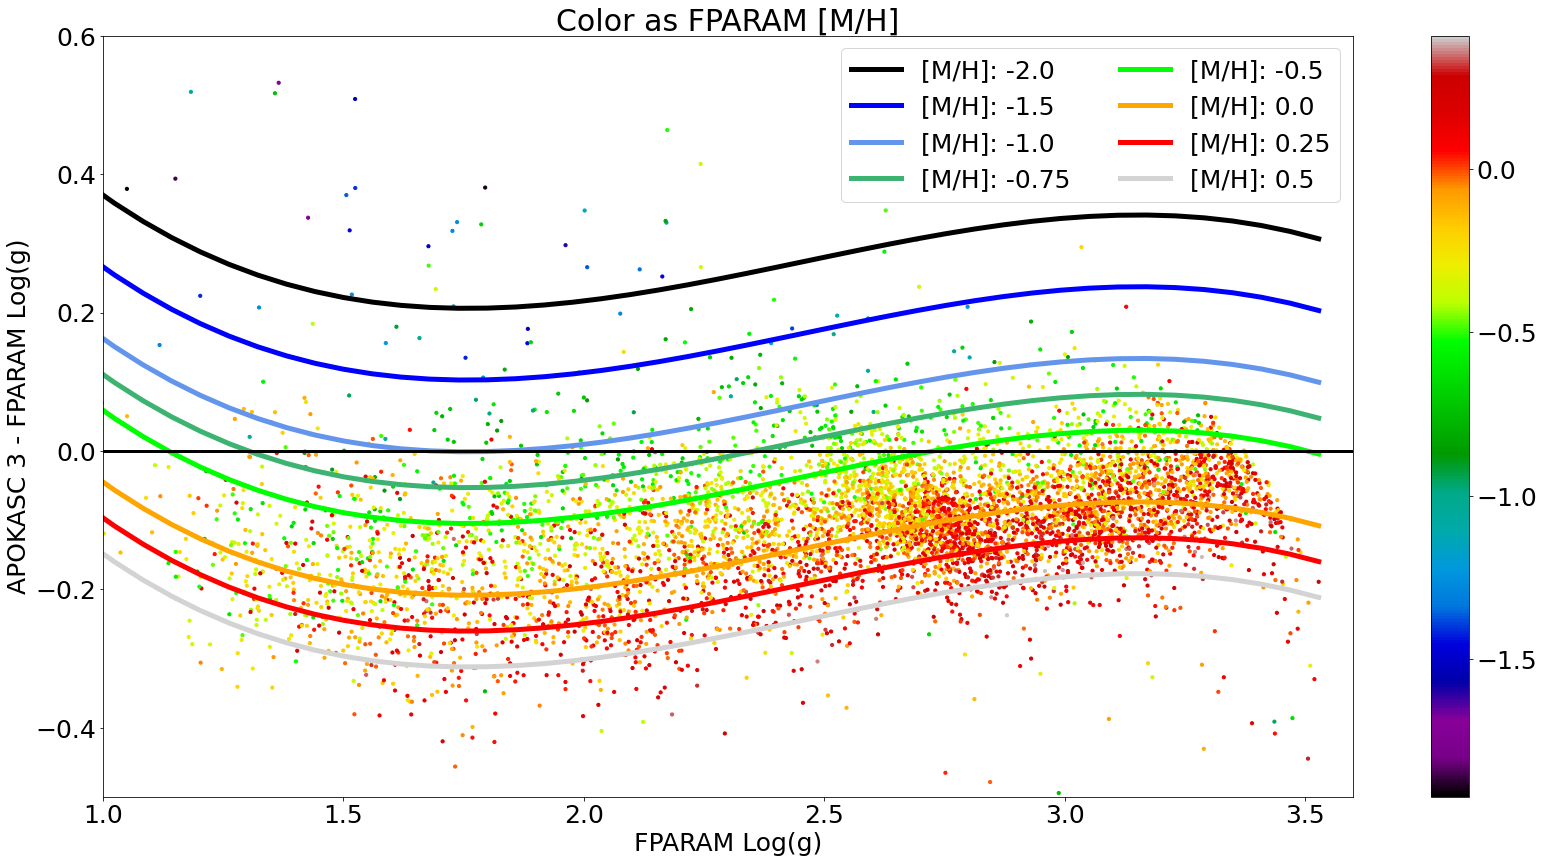

In [16]:
def logg_cal_corr(X,a,b,c,d,e):
    '''
    ASPCAP Log(g) similar to calibration from J\"{o}nsson et al. 2020 without the conditions
    
    Inputs:
    ------
        logg: uncalibrated log(g) value (FPARAM[1])
        mh: unclaibrated [M/H] value (FPARAM[3])
    
    Output:
    ------
        cal_logg: calibrated Log(g) value
    '''
    
    logg, mh = X
    
    return logg - (-a + b*logg + c*logg**2 + d*logg**3 + e*mh)

fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(kdr17['FPARAM'][:,3])==True)&
                  (np.isfinite(k674['APOKASC3P_LOGG'])==True))

popt_logg_cal, _ = curve_fit(logg_cal_corr,(kdr17['FPARAM'][:,1][fincut],kdr17['FPARAM'][:,3][fincut]),
                             (k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1])[fincut])

param_labels = np.array(['a','b','c','d','e'])
jonsson_coeffs = np.array([-0.441,0.7588,-0.2667,0.02819,0.1346])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}; {:.5f}'.format(param_labels[i],popt_logg_cal[i],jonsson_coeffs[i]))
    
### Plot
plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

xs_logg = np.linspace(np.nanmin(kdr17['FPARAM'][:,1]),np.nanmax(kdr17['FPARAM'][:,1]))
test_mhs = np.array([-2.00,-1.50,-1.00,-0.75,-0.50,0.0,0.25,0.50])
color_mhs = np.array(['k','b','cornflowerblue','mediumseagreen','lime','orange','red','lightgrey'])
for i in range(len(test_mhs)):
    plt.plot(xs_logg,logg_cal_corr((xs_logg,test_mhs[i]),*popt_logg_cal),
             label='[M/H]: {}'.format(test_mhs[i]),lw=5.0,c=color_mhs[i])

plt.legend(ncol=2)
plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.6)
plt.ylim(-0.5,0.6)

plt.title(r'Color as FPARAM [M/H]')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.show()

Fit Parameters:
a = 0.97583; -0.44100
b = 1.65432; 0.75880
c = -0.73250; -0.26670
d = 0.09939; 0.02819
e = 0.20734; 0.13460


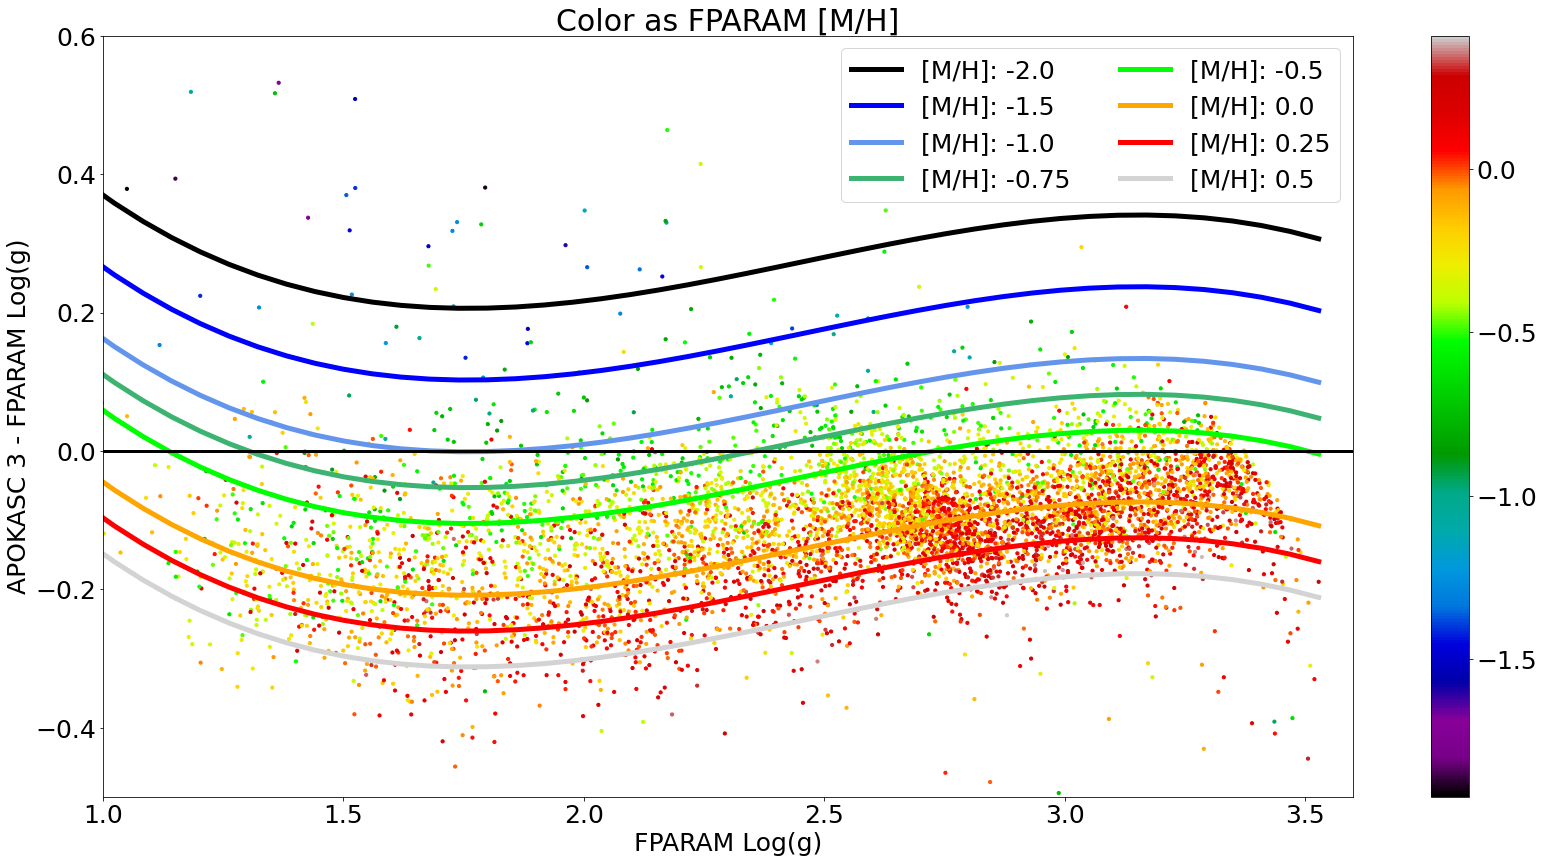

In [17]:
def logg_cal(X,a,b,c,d,e):
    '''
    ASPCAP Log(g) similar to calibration from J\"{o}nsson et al. 2020 without the conditions
    
    Inputs:
    ------
        logg: uncalibrated log(g) value (FPARAM[1])
        mh: unclaibrated [M/H] value (FPARAM[3])
    
    Output:
    ------
        cal_logg: calibrated Log(g) value
    '''
    
    logg, mh = X
    
    return logg - (-a + b*logg + c*logg**2 + d*logg**3 + e*mh)


fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(kdr17['FPARAM'][:,3])==True)&
                  (np.isfinite(k674['APOKASC3P_LOGG'])==True))

popt_logg_cal, _ = curve_fit(logg_cal_corr,(kdr17['FPARAM'][:,1][fincut],kdr17['FPARAM'][:,3][fincut]),
                             (k674['APOKASC3P_LOGG'])[fincut])

param_labels = np.array(['a','b','c','d','e'])
jonsson_coeffs = np.array([-0.441,0.7588,-0.2667,0.02819,0.1346])
print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}; {:.5f}'.format(param_labels[i],popt_logg_cal[i],jonsson_coeffs[i]))
    
### Plot
plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

xs_logg = np.linspace(np.nanmin(kdr17['FPARAM'][:,1]),np.nanmax(kdr17['FPARAM'][:,1]))
test_mhs = np.array([-2.00,-1.50,-1.00,-0.75,-0.50,0.0,0.25,0.50])
color_mhs = np.array(['k','b','cornflowerblue','mediumseagreen','lime','orange','red','lightgrey'])
for i in range(len(test_mhs)):
    plt.plot(xs_logg,logg_cal((xs_logg,test_mhs[i]),*popt_logg_cal)-xs_logg,
             label='[M/H]: {}'.format(test_mhs[i]),lw=5.0,c=color_mhs[i])

plt.legend(ncol=2)
plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.6)
plt.ylim(-0.5,0.6)

plt.title(r'Color as FPARAM [M/H]')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.show()

In [18]:
popt_logg_cal2, _ = curve_fit(logg_cal_corr,(kdr17['FPARAM'][:,1][fincut],kdr17['FPARAM'][:,3][fincut]),
                             (k674['APOKASC3P_LOGG'])[fincut])
popt_logg_cal3, _ = curve_fit(logg_cal,(kdr17['FPARAM'][:,1][fincut],kdr17['FPARAM'][:,3][fincut]),
                             (k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1])[fincut])

print('APOKASC',popt_logg_cal2)
print('APOKASC-ASPCAP',popt_logg_cal3)

APOKASC [ 0.97583247  1.65432116 -0.73249556  0.09939404  0.2073412 ]
APOKASC-ASPCAP [ 0.97583238  2.65432102 -0.7324955   0.09939403  0.2073412 ]


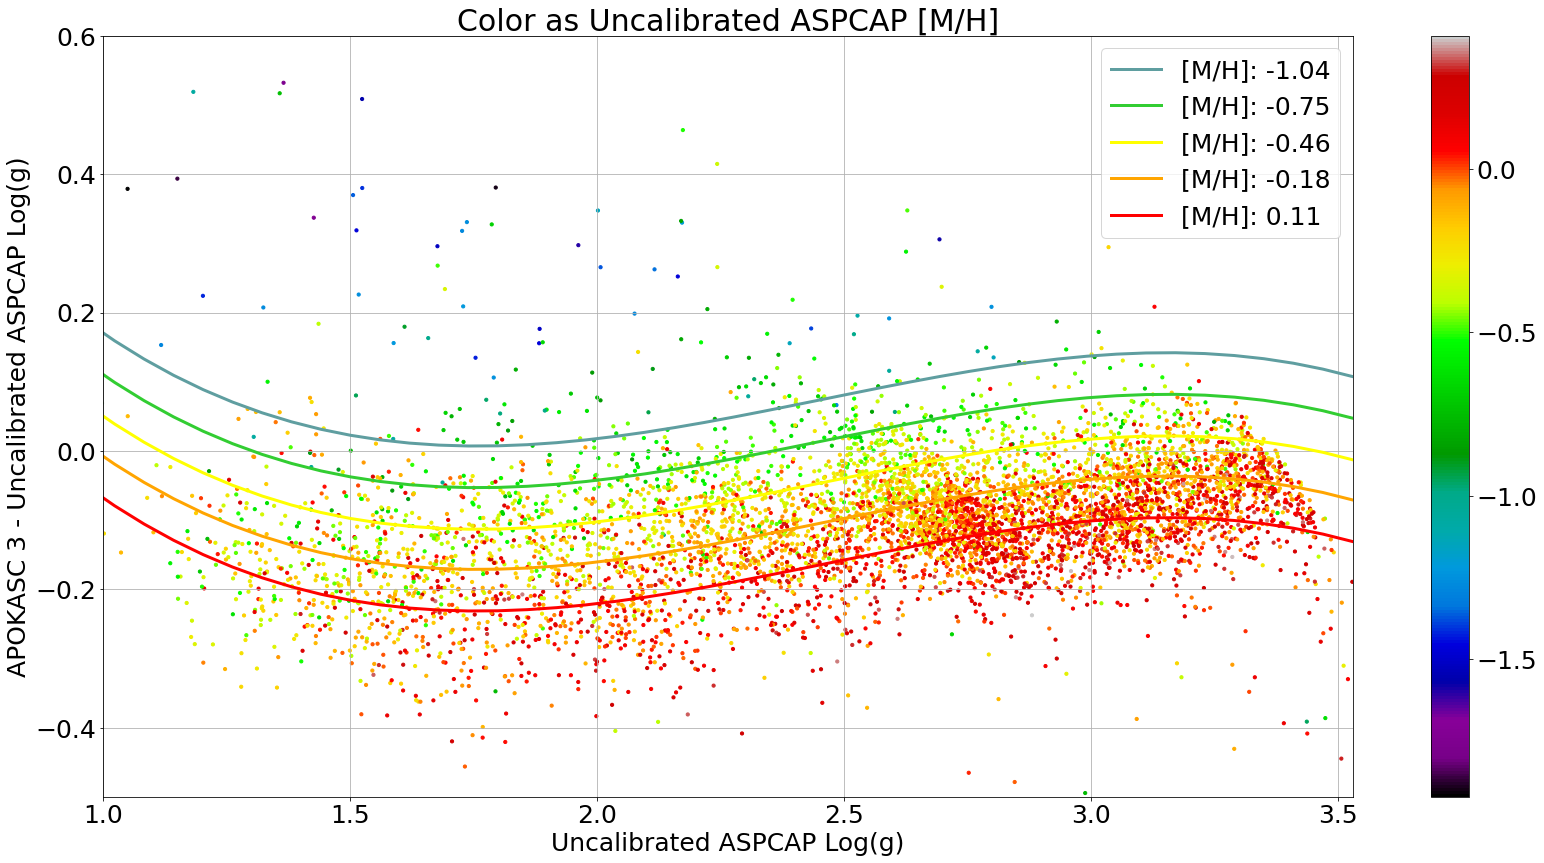

In [19]:
# test_mhs2 = np.array([-1.90,-1.62,-1.33,-1.04,-0.75,-0.46,-0.18,0.11,0.40])
# colors_mhs2 = np.array(['k','darkblue','cornflowerblue','teal','limegreen','yellow','orange','red','lightgrey'])

test_mhs2 = np.array([-1.04,-0.75,-0.46,-0.18,0.11])
colors_mhs2 = np.array(['cadetblue','limegreen','yellow','orange','red'])


### Plot
plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

xs_logg = np.linspace(np.nanmin(kdr17['FPARAM'][:,1]),np.nanmax(kdr17['FPARAM'][:,1]))

ys = np.array([-0.3,-0.18,-0.05,0.1,0.2])
for i in range(len(test_mhs2)):
    plt.plot(xs_logg,logg_cal((xs_logg,test_mhs2[i]),*popt_logg_cal)-xs_logg,lw=3.0,c=colors_mhs2[i],
             label='[M/H]: {}'.format(test_mhs2[i]))
    
plt.legend()
    
plt.colorbar()

# plt.axhline(0.0,c='k',lw=5.0)

plt.grid()

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.53)
plt.ylim(-0.5,0.6)

plt.title(r'Color as Uncalibrated ASPCAP [M/H]')
plt.xlabel(r'Uncalibrated ASPCAP Log(g)')
plt.ylabel(r'APOKASC 3 - Uncalibrated ASPCAP Log(g)')
plt.savefig('../plots/seismic_spectro_logg_trends.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [20]:
import numpy as np
np.mean((0.4,-0.18))

0.11000000000000001

In [21]:
max(kdr17['FPARAM'][:,3])
min(kdr17['FPARAM'][:,3])

-1.9219

0.00082325935
0.040727854


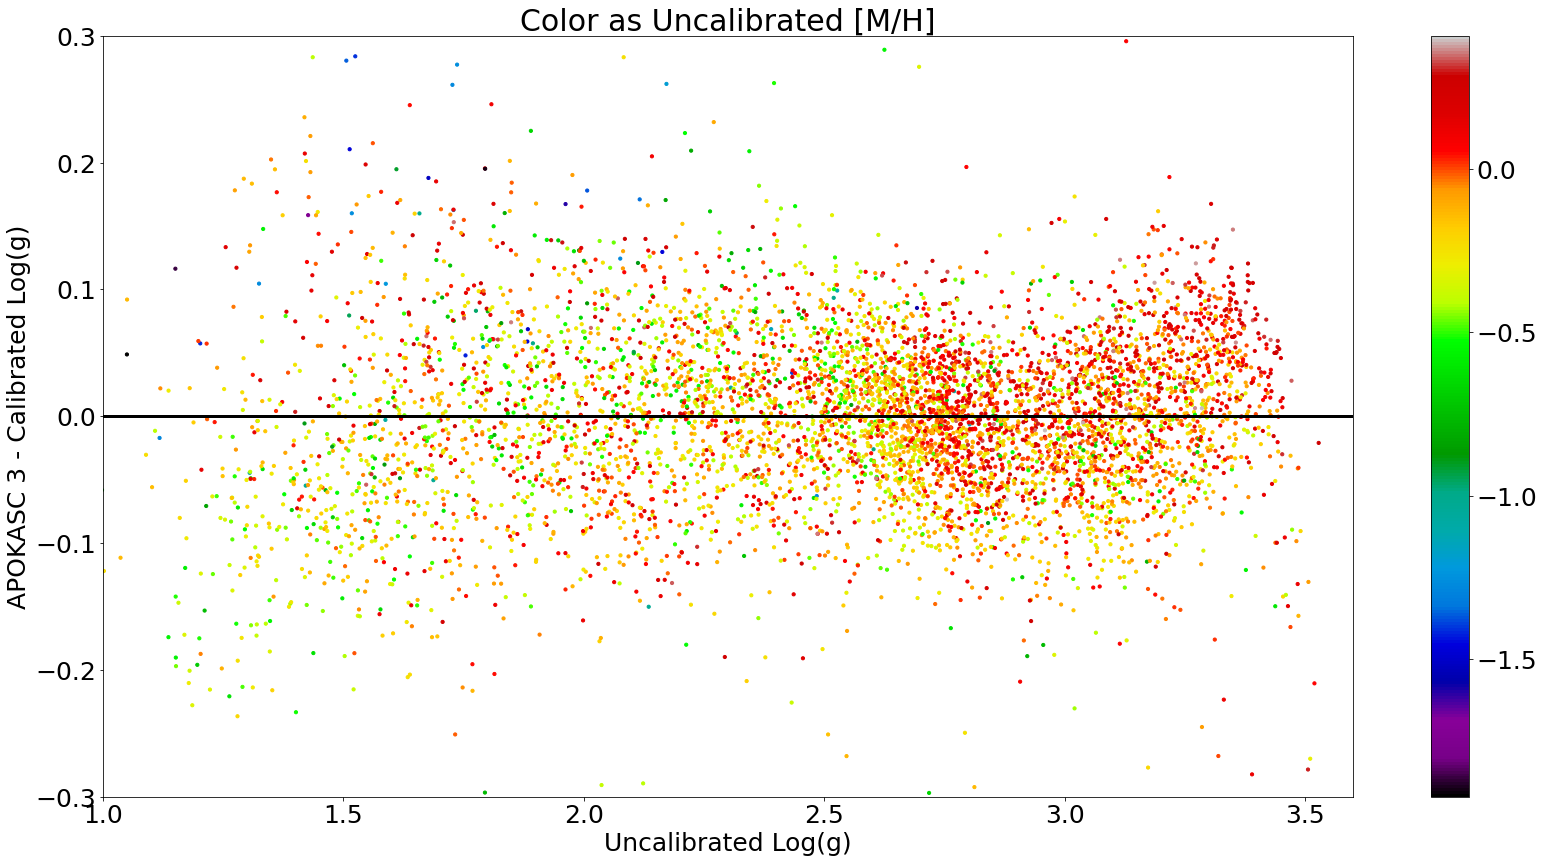

In [36]:
logg_corr_fac = logg_cal_corr((kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]),*popt_logg_cal)

### Plot

print(np.nanmedian(k674['APOKASC3P_LOGG']-(logg_corr_fac)))
print(mad(k674['APOKASC3P_LOGG']-(logg_corr_fac)))

plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-(logg_corr_fac),
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.6)
plt.ylim(-0.3,0.3)

plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Log(g)')
plt.ylabel(r'APOKASC 3 - Calibrated Log(g)')
plt.savefig('../plots/seismic_spectro_logg_resid.pdf',dpi=300,bbox_inches='tight')
plt.show()

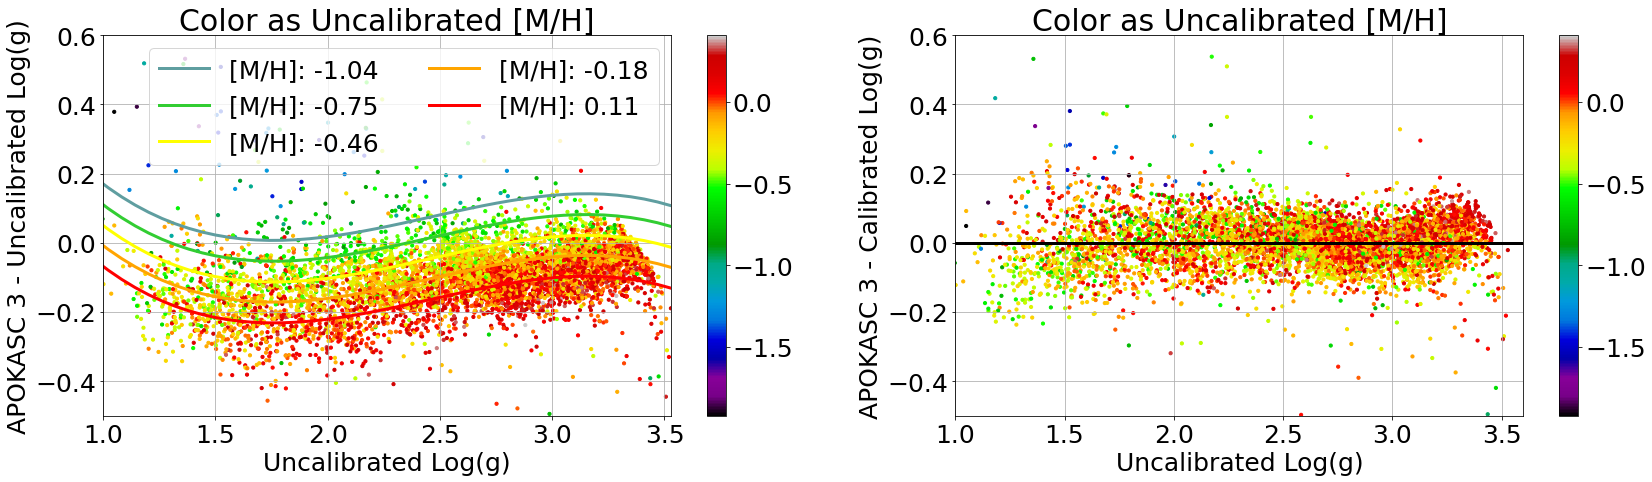

In [47]:
### Plot
plt.figure(figsize=[28,7])
plt.subplot(121)
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

xs_logg = np.linspace(np.nanmin(kdr17['FPARAM'][:,1]),np.nanmax(kdr17['FPARAM'][:,1]))

ys = np.array([-0.3,-0.18,-0.05,0.1,0.2])
for i in range(len(test_mhs2)):
    plt.plot(xs_logg,logg_cal((xs_logg,test_mhs2[i]),*popt_logg_cal)-xs_logg,lw=3.0,c=colors_mhs2[i],
             label='[M/H]: {}'.format(test_mhs2[i]))
    
plt.legend(ncol=2)
    
plt.colorbar()

# plt.axhline(0.0,c='k',lw=5.0)

plt.grid()

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.53)
plt.ylim(-0.5,0.6)

plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Log(g)')
plt.ylabel(r'APOKASC 3 - Uncalibrated Log(g)')

plt.subplot(122)
# plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-(logg_corr_fac),
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.grid()

plt.xlim(1.0,3.6)
plt.ylim(-0.3,0.3)
plt.ylim(-0.5,0.6)

plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Log(g)')
plt.ylabel(r'APOKASC 3 - Calibrated Log(g)')
plt.savefig('../plots/seismic_spectro_logg_full.pdf',dpi=300,bbox_inches='tight')
plt.show()


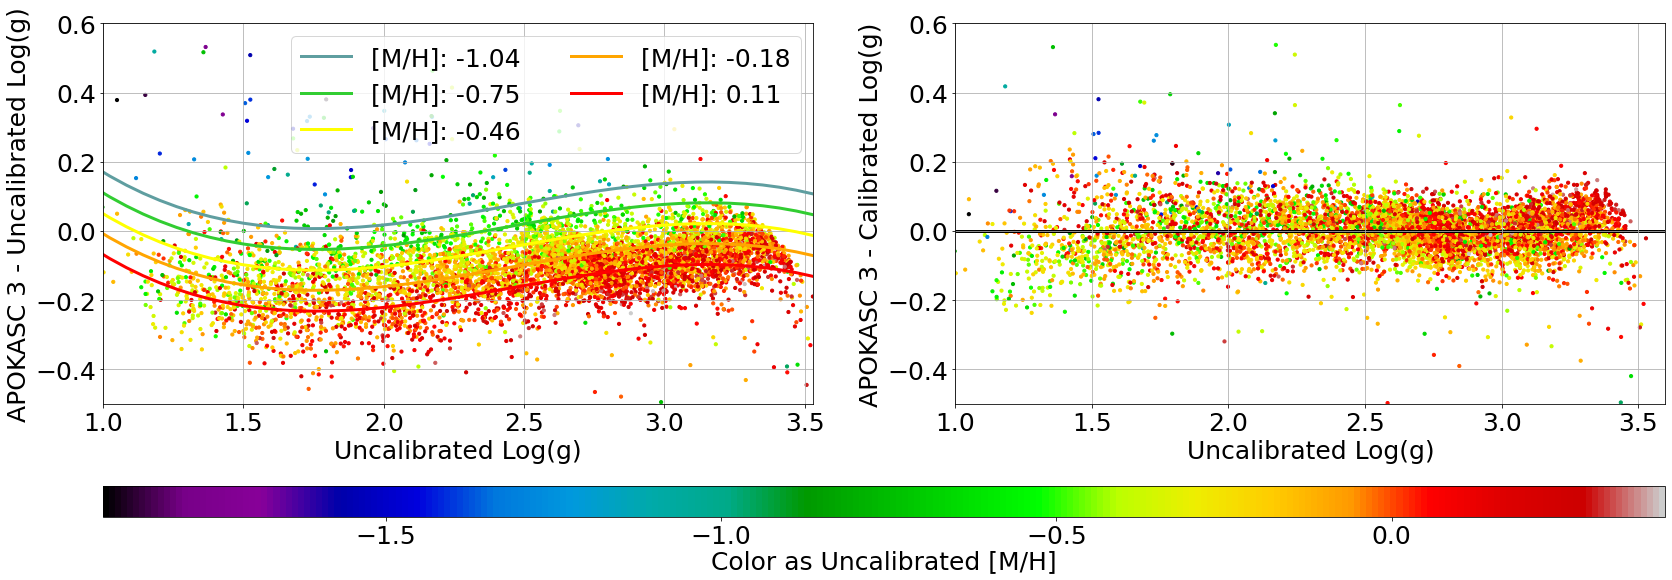

In [66]:
### Plot
fig,ax = plt.subplots(1,2,figsize=[28,10]) #= figure(figsize=[28,7])

im = ax[0].scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
                   c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10,zorder=0)
# ax[0].axhline(0.0,c='k',lw=3.0,zorder=1)

xs_logg = np.linspace(np.nanmin(kdr17['FPARAM'][:,1]),np.nanmax(kdr17['FPARAM'][:,1]))

ys = np.array([-0.3,-0.18,-0.05,0.1,0.2])
for i in range(len(test_mhs2)):
    ax[0].plot(xs_logg,logg_cal((xs_logg,test_mhs2[i]),*popt_logg_cal)-xs_logg,lw=3.0,c=colors_mhs2[i],
             label='[M/H]: {}'.format(test_mhs2[i]))
    
ax[0].legend(ncol=2)

ax[0].grid()

ax[0].set_xticks(np.arange(0,4.0,0.5))

ax[0].set_xlim(1.0,3.53)
ax[0].set_ylim(-0.5,0.6)

# ax[0].set_title(r'Color as Uncalibrated [M/H]')
ax[0].set_xlabel(r'Uncalibrated Log(g)')
ax[0].set_ylabel(r'APOKASC 3 - Uncalibrated Log(g)')

# plt.subplot(122)
# plt.figure(figsize=[28,14])
im = ax[1].scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-(logg_corr_fac),
                   c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10,zorder=0)

ax[1].axhline(0.0,c='k',lw=3.0,zorder=1)

ax[1].set_xticks(np.arange(0,4.0,0.5))

ax[1].grid()

ax[1].set_xlim(1.0,3.6)
# ax[1].set_ylim(-0.3,0.3)
ax[1].set_ylim(-0.5,0.6)

ax[1].set_xlabel(r'Uncalibrated Log(g)')
ax[1].set_ylabel(r'APOKASC 3 - Calibrated Log(g)')

cbar = fig.colorbar(im,orientation='horizontal',aspect=50,ax=ax.ravel().tolist())
cbar.set_label('Color as Uncalibrated [M/H]',labelpad=1)

# plt.suptitle(r'Color as Uncalibrated [M/H]')
plt.savefig('../plots/seismic_spectro_logg_full.pdf',dpi=300,bbox_inches='tight')
plt.show()

Median Residual:  -2.6597733
Median Absolute Deviation:  0.40384698


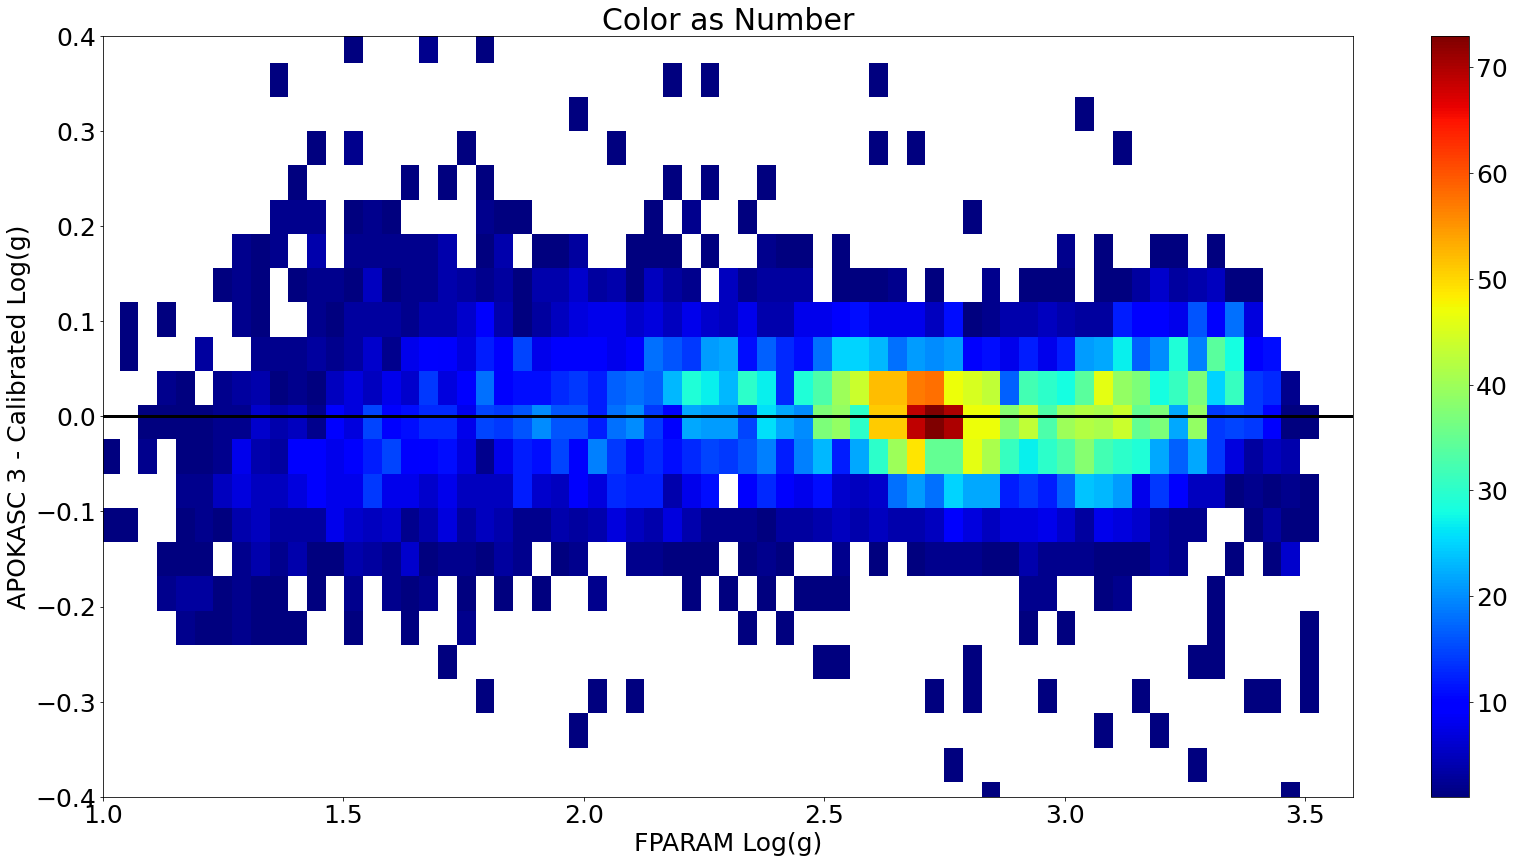

In [35]:
### Plot

print('Median Residual: ',np.nanmedian(k674['APOKASC3P_LOGG']-(kdr17['FPARAM'][:,1]+logg_corr_fac)))
print('Median Absolute Deviation: ',mad(k674['APOKASC3P_LOGG']-(kdr17['FPARAM'][:,1]+logg_corr_fac)))

fincut = np.where((np.isfinite(k674['APOKASC3P_LOGG'])==True)&(np.isfinite(kdr17['FPARAM'][:,1])==True))
ret = binned_statistic_2d(kdr17['FPARAM'][:,1][fincut],k674['APOKASC3P_LOGG'][fincut]-
                          (logg_corr_fac)[fincut],kdr17['FPARAM'][:,1][fincut],
                          'count',bins=75)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[28,14])

plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.6)
plt.ylim(-0.4,0.4)

plt.title(r'Color as Number')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - Calibrated Log(g)')
plt.show()

Median Residual:  0.10003657202393468
Median Absolute Deviation:  0.045331560131499415


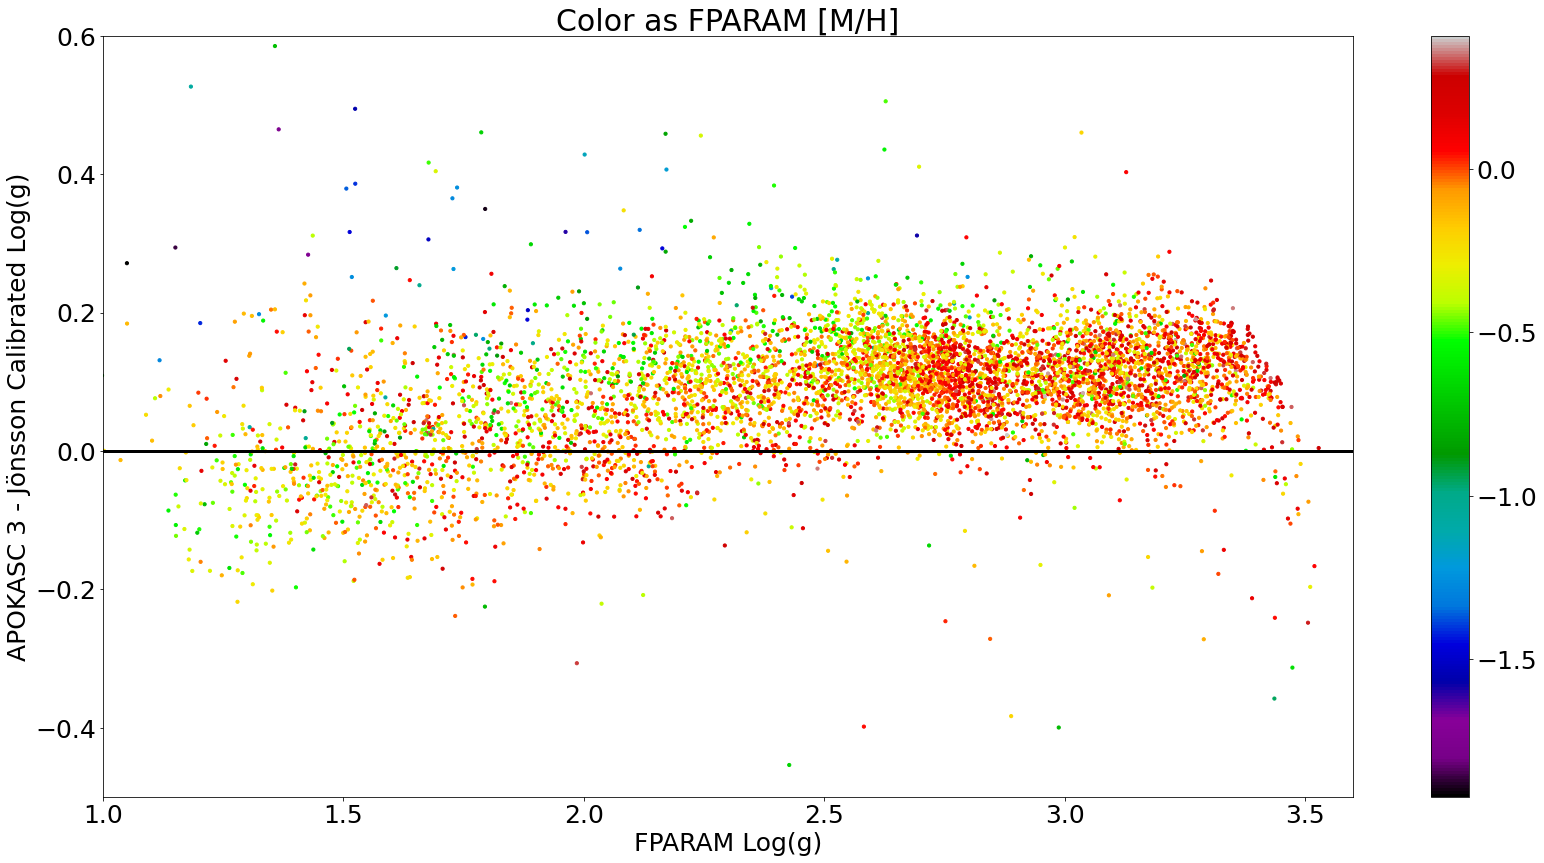

In [24]:
print('Median Residual: ',
      np.nanmedian(k674['APOKASC3P_LOGG']-logg_cal_jonsson(kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3])))
print('Median Absolute Deviation: ',
      mad(k674['APOKASC3P_LOGG']-logg_cal_jonsson(kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3])))

### Plot
plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-
            logg_cal_jonsson(kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]),
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.6)
plt.ylim(-0.5,0.6)

plt.title(r'Color as FPARAM [M/H]')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - Jönsson Calibrated Log(g)')
plt.show()

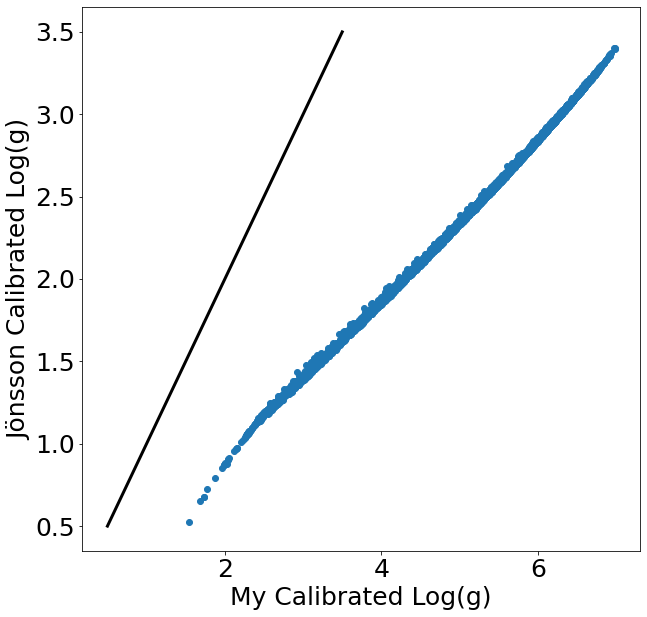

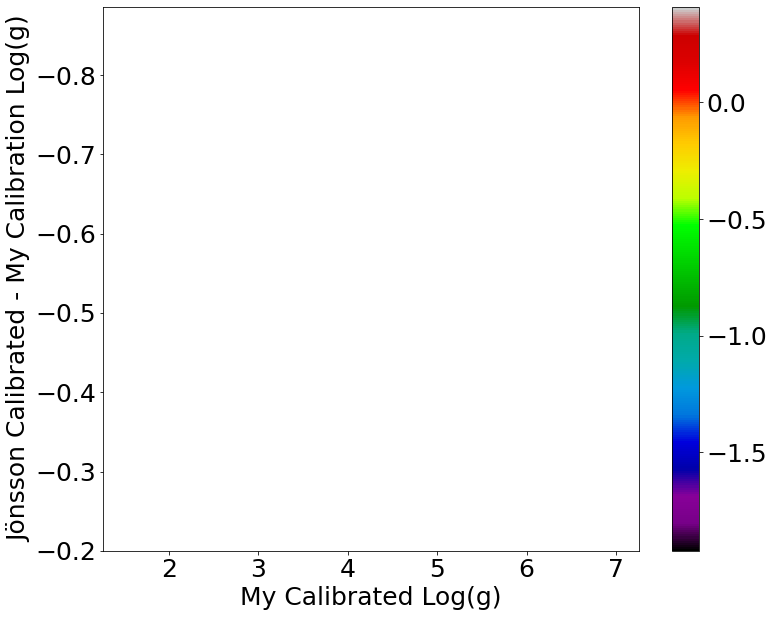

In [25]:
plt.figure(figsize=[10,10])
plt.scatter(kdr17['FPARAM'][:,1]+logg_corr_fac,logg_cal_jonsson(kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]))
plt.plot([0.5,3.5],[0.5,3.5],c='k',lw=3.0)

plt.xlabel(r'My Calibrated Log(g)')
plt.ylabel(r'Jönsson Calibrated Log(g)')
plt.show()

###
plt.figure(figsize=[12,10])
plt.scatter(kdr17['FPARAM'][:,1]+logg_corr_fac,
            logg_cal_jonsson(kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3])-(kdr17['FPARAM'][:,1]+logg_corr_fac),
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral')
plt.colorbar()

plt.ylim(bottom=-0.2)

plt.xlabel(r'My Calibrated Log(g)')
plt.ylabel(r'Jönsson Calibrated - My Calibration Log(g)')
plt.show()

# Calculate the shift in FPARAM logg as a function of FPARAM logg

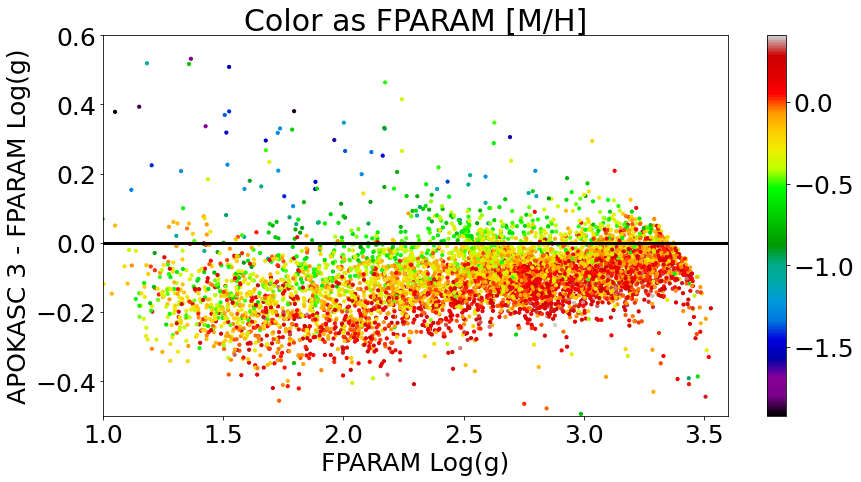

In [10]:
plt.figure(figsize=[14,7])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.6)
plt.ylim(-0.5,0.6)

plt.title(r'Color as FPARAM [M/H]')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.show()

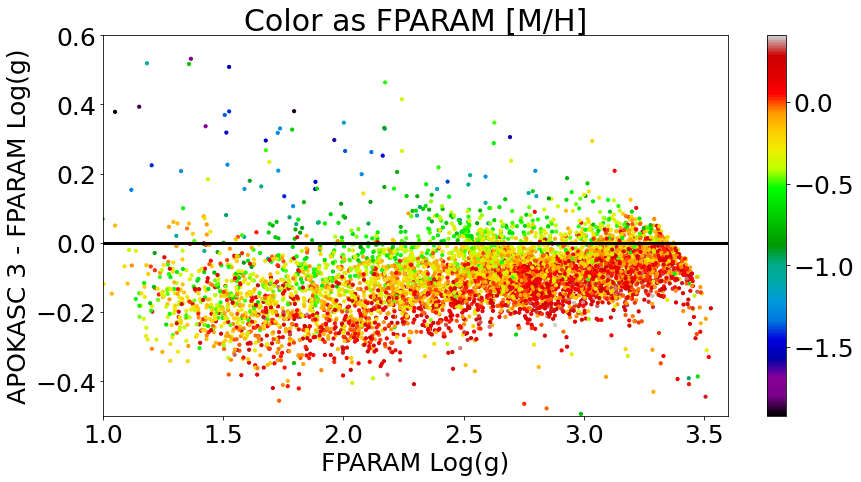

In [11]:
plt.figure(figsize=[14,7])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.6)
plt.ylim(-0.5,0.6)

plt.title(r'Color as FPARAM [M/H]')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.show()

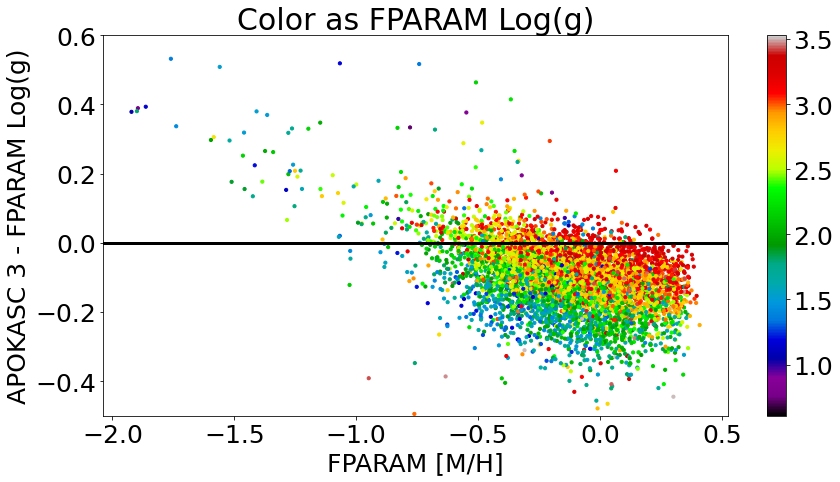

In [12]:
plt.figure(figsize=[14,7])
plt.scatter(kdr17['FPARAM'][:,3],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,1],cmap='nipy_spectral',s=10)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.5,0.6)

plt.title(r'Color as FPARAM Log(g)')
plt.xlabel(r'FPARAM [M/H]')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.show()